In [ ]:
# Kernel 1: Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator




In [ ]:
from google.colab import files
uploaded = files.upload()



Saving Project images-20250204T073502Z-001 (1).zip to Project images-20250204T073502Z-001 (1).zip


In [ ]:
!unzip -q "/content/Project images-20250204T073502Z-001 (1).zip" -d "/content/data"


In [ ]:
import os

print("Folders in /content/data:", os.listdir("/content/data"))


Folders in /content/data: ['Project images']


In [ ]:
base_dir = "/content/data/Project images-20250204T073502Z-001"



In [ ]:
import os

print("Folders in /content/data:", os.listdir("/content/data"))


Folders in /content/data: ['Project images']


In [ ]:
base_dir = "/content/data/Project images"


In [ ]:
import os

print("Folders in /content/data/Project images:", os.listdir(base_dir))


Folders in /content/data/Project images: ['5mm,600 RPM,100x-5000x', '10mm,600 RPM, 100x-5000x', '10mm,400 RPM, 100x-5000x']


In [ ]:
import os

base_dir = "/content/data/Project images"

# Check what's inside one of the main folders
for main_folder in os.listdir(base_dir):
    main_path = os.path.join(base_dir, main_folder)
    if os.path.isdir(main_path):
        print(f"Checking inside: {main_folder}")
        print("Subfolders:", os.listdir(main_path))  # Should list: ['100x', '500x', '1000x', '2000x', '5000x']
        break  # Only check the first one


Checking inside: 5mm,600 RPM,100x-5000x
Subfolders: ['5000x', '2000x']


In [ ]:
import cv2
import numpy as np
import os

def load_images_2000x(base_dir):
    data = []
    labels = []

    for main_folder in os.listdir(base_dir):
        main_path = os.path.join(base_dir, main_folder)

        if os.path.isdir(main_path):
            # Case-insensitive search for "2000x"
            mag_folders = [f for f in os.listdir(main_path) if f.lower() == "2000x"]
            if mag_folders:
                mag_path = os.path.join(main_path, mag_folders[0])  # Use correct case

                for img_file in os.listdir(mag_path):
                    if img_file.endswith(".tif"):
                        time_label = img_file.split("_")[0]  # Extract time (24h, 48h, 72h)
                        img_path = os.path.join(mag_path, img_file)

                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (128, 128))  # Resize for consistency
                        img = img / 255.0  # Normalize

                        data.append(img)
                        labels.append((main_folder, "2000x", time_label))

    return np.array(data), labels

# Set correct base directory
base_dir = "/content/data/Project images"

# Load the dataset
data, labels = load_images_2000x(base_dir)
print("Dataset loaded with", len(data), "images for 2000x magnification.")


Dataset loaded with 6 images for 2000x magnification.


In [ ]:
for main_folder in os.listdir(base_dir):
    main_path = os.path.join(base_dir, main_folder)
    if os.path.isdir(main_path):
        mag_folders = [f for f in os.listdir(main_path) if f.lower() == "2000x"]
        if mag_folders:
            mag_path = os.path.join(main_path, mag_folders[0])
            print(f"{main_folder} -> {len(os.listdir(mag_path))} images found")


5mm,600 RPM,100x-5000x -> 3 images found
10mm,400 RPM, 100x-5000x -> 3 images found


In [ ]:
for main_folder in os.listdir(base_dir):
    main_path = os.path.join(base_dir, main_folder)
    if os.path.isdir(main_path):
        mag_folders = [f for f in os.listdir(main_path) if f.lower() == "2000x"]
        if mag_folders:
            mag_path = os.path.join(main_path, mag_folders[0])
            print(f"\nChecking {main_folder}/2000x")
            print(os.listdir(mag_path))  # List all files inside 2000x



Checking 5mm,600 RPM,100x-5000x/2000x
['48 HRS.tif', '24 HRS.tif', '72 HRS.tif']

Checking 10mm,400 RPM, 100x-5000x/2000x
['24 hrs.tif', '48 hrs.tif', '72 HRS.tif']


In [ ]:
import cv2

def calculate_sphericity(image):
    """Calculate sphericity of detected particles in an image."""
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)  # Convert to binary
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sphericity_list = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)

        if perimeter == 0:
            continue

        sphericity = (4 * np.pi * area) / (perimeter ** 2)  # Sphericity formula
        sphericity_list.append(sphericity)

    return np.mean(sphericity_list) if sphericity_list else 0  # Return average sphericity

# Calculate sphericity for each image
sphericity_results = []
for i, img in enumerate(data):
    sphericity = calculate_sphericity((img * 255).astype(np.uint8))  # Convert back to 8-bit
    sphericity_results.append((labels[i][0], labels[i][1], labels[i][2], sphericity))  # Folder, mag, time, sphericity

print("Sphericity extraction completed.")


Sphericity extraction completed.


In [ ]:
from sklearn.model_selection import train_test_split

# Reshape data for CNN input (Add channel dimension)
X = np.expand_dims(data, axis=-1)  # Shape: (num_samples, 128, 128, 1)
y = np.array([s[3] for s in sphericity_results])  # Extract sphericity values

# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data prepared for CNN training.")


Data prepared for CNN training.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')  # Regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("CNN model defined.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN model defined.


In [ ]:
# Train CNN model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=8)

# Save model for future use
model.save("/content/sphericity_cnn_model.h5")

print("CNN model training completed and saved.")


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0325 - mae: 0.1647 - val_loss: 4.5705 - val_mae: 2.1232
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - loss: 3.5542 - mae: 1.8558 - val_loss: 0.2875 - val_mae: 0.5334
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 0.1624 - mae: 0.3898 - val_loss: 0.0291 - val_mae: 0.1675
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step - loss: 0.0564 - mae: 0.1897 - val_loss: 0.1073 - val_mae: 0.3235
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step - loss: 0.1691 - mae: 0.3972 - val_loss: 0.0615 - val_mae: 0.2447
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - loss: 0.1156 - mae: 0.3248 - val_loss: 0.0200 - val_mae: 0.1393
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 0.0371 - mae: 0.1783 - val_loss: 0.0030 - val_mae: 0.0531
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - loss: 0.0143 - mae: 0.1161 - val_loss: 0.0015 - val_mae: 0.0385
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - loss: 0.0071 - mae: 0.0

CNN model training completed and saved.


In [ ]:
# Function to predict sphericity
def predict_sphericity(model, image_data, labels):
    predictions = model.predict(image_data)
    results = []
    for i in range(len(predictions)):
        condition = labels[i]  # (Magnification, Time)
        sphericity = predictions[i][0]  # Extract single value
        results.append([condition[0], condition[1], sphericity])
    return results

# Make predictions
sphericity_results = predict_sphericity(model, data, labels)

# Convert to DataFrame
df_sphericity = pd.DataFrame(sphericity_results, columns=["Magnification", "Time", "Predicted Sphericity"])
print(df_sphericity.head())

# Save to CSV
df_sphericity.to_csv("/content/sphericity_results.csv", index=False)
print("Sphericity predictions saved to 'sphericity_results.csv'.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
              Magnification   Time  Predicted Sphericity
0    5mm,600 RPM,100x-5000x  2000x              0.239265
1    5mm,600 RPM,100x-5000x  2000x              0.177480
2    5mm,600 RPM,100x-5000x  2000x              0.224903
3  10mm,400 RPM, 100x-5000x  2000x              0.186712
4  10mm,400 RPM, 100x-5000x  2000x              0.240606
Sphericity predictions saved to 'sphericity_results.csv'.


In [ ]:
# Define an arbitrary threshold for "good" sphericity (e.g., 0.8+)
optimal_sphericity_threshold = 0.8

# Identify best conditions
optimal_conditions = df_sphericity[df_sphericity["Predicted Sphericity"] >= optimal_sphericity_threshold]

# Save to CSV
optimal_conditions.to_csv("/content/optimized_parameters.csv", index=False)
print("Optimized parameter set saved to 'optimized_parameters.csv'.")


Optimized parameter set saved to 'optimized_parameters.csv'.


In [ ]:
import pandas as pd

# Load the saved predictions
df_sphericity = pd.read_csv("/content/sphericity_results.csv")

# Display first few rows
print(df_sphericity.head())

# Check the range of sphericity values
print("Sphericity range:", df_sphericity["Predicted Sphericity"].min(), "to", df_sphericity["Predicted Sphericity"].max())


              Magnification   Time  Predicted Sphericity
0    5mm,600 RPM,100x-5000x  2000x              0.239265
1    5mm,600 RPM,100x-5000x  2000x              0.177480
2    5mm,600 RPM,100x-5000x  2000x              0.224903
3  10mm,400 RPM, 100x-5000x  2000x              0.186712
4  10mm,400 RPM, 100x-5000x  2000x              0.240606
Sphericity range: 0.17748 to 0.24060641


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

def load_microstructure_images(base_path, magnification="2000x"):
    data, labels = [], []

    for main_folder in os.listdir(base_path):  # e.g., "5mm_600RPM", "10mm_400RPM"
        main_path = os.path.join(base_path, main_folder)
        if not os.path.isdir(main_path):
            continue

        mag_path = os.path.join(main_path, magnification)
        if not os.path.exists(mag_path):
            continue

        for img_name in os.listdir(mag_path):  # e.g., "24 hrs.tif"
            if img_name.endswith(".tif"):
                time_label = img_name.split(" ")[0]  # Extract "24", "48", "72"
                img_path = os.path.join(mag_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (128, 128))  # Standardize size
                data.append(img / 255.0)  # Normalize
                labels.append((main_folder, magnification, time_label))

    return np.array(data), labels

def calculate_sphericity(image):
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sphericity_list = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        sphericity = (4 * np.pi * area) / (perimeter ** 2)
        sphericity_list.append(sphericity)

    return np.mean(sphericity_list) if sphericity_list else 0

# Load dataset
base_path = "/content/data/Project images"
data, labels = load_microstructure_images(base_path)

# Compute sphericity
sphericity_results = [(l[0], l[1], l[2], calculate_sphericity((img * 255).astype(np.uint8))) for img, l in zip(data, labels)]

data = np.expand_dims(data, axis=-1)  # Reshape for CNN input
y = np.array([s[3] for s in sphericity_results])

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=8)

# Save model
model.save("sphericity_cnn_model.h5")

def predict_sphericity(model, image_data, labels):
    predictions = model.predict(image_data)
    return [[l[0], l[1], l[2], p[0]] for l, p in zip(labels, predictions)]

sphericity_results = predict_sphericity(model, data, labels)
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])
df_sphericity.to_csv("sphericity_results.csv", index=False)
print(df_sphericity)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0209 - mae: 0.1398 - val_loss: 9.5118 - val_mae: 3.0575
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 10.4927 - mae: 3.1158 - val_loss: 0.0442 - val_mae: 0.2093
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0210 - mae: 0.1382 - val_loss: 0.3391 - val_mae: 0.5757
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step - loss: 0.5964 - mae: 0.7127 - val_loss: 0.2362 - val_mae: 0.4797
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step - loss: 0.2939 - mae: 0.5266 - val_loss: 0.1377 - val_mae: 0.3655
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - loss: 0.1966 - mae: 0.4123 - val_loss: 0.0762 - val_mae: 0.2717
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.1188 - mae: 0.3380 - val_loss: 0.0379 - val_mae: 0.1913
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step - loss: 0.0558 - mae: 0.2338 - val_loss: 0.0152 - val_mae: 0.1215
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.0251 - mae: 0.1544 - val_loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
             Ball Size, RPM Magnification Time  Predicted Sphericity
0    5mm,600 RPM,100x-5000x         2000x   48              0.201731
1    5mm,600 RPM,100x-5000x         2000x   24              0.147541
2    5mm,600 RPM,100x-5000x         2000x   72              0.179822
3  10mm,400 RPM, 100x-5000x         2000x   24              0.154589
4  10mm,400 RPM, 100x-5000x         2000x   48              0.196062
5  10mm,400 RPM, 100x-5000x         2000x   72              0.200505


In [ ]:
# calculation of sphericity

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# 🔹 Set all random seeds to ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Ensure deterministic TensorFlow operations
tf.config.experimental.enable_op_determinism()

def load_microstructure_images(base_path, magnification="2000x"):
    data, labels = [], []

    # 🔹 Sort main folders to ensure order is the same every time
    for main_folder in sorted(os.listdir(base_path)):  # e.g., "5mm_600RPM", "10mm_400RPM"
        main_path = os.path.join(base_path, main_folder)
        if not os.path.isdir(main_path):
            continue

        mag_path = os.path.join(main_path, magnification)
        if not os.path.exists(mag_path):
            continue

        # 🔹 Sort images by name to maintain order
        for img_name in sorted(os.listdir(mag_path)):  # e.g., "24 hrs.tif"
            if img_name.endswith(".tif"):
                time_label = img_name.split(" ")[0]  # Extract "24", "48", "72"
                img_path = os.path.join(mag_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (128, 128))  # Standardize size
                data.append(img / 255.0)  # Normalize
                labels.append((main_folder, magnification, time_label))

    return np.array(data), labels

def calculate_sphericity(image):
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sphericity_list = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        sphericity = (4 * np.pi * area) / (perimeter ** 2)
        sphericity_list.append(sphericity)

    return np.mean(sphericity_list) if sphericity_list else 0

# 🔹 Load dataset with sorted order
base_path = "/content/data/Project images"
data, labels = load_microstructure_images(base_path)

# 🔹 Compute sphericity (ensures order remains unchanged)
sphericity_results = [(l[0], l[1], l[2], calculate_sphericity((img * 255).astype(np.uint8))) for img, l in zip(data, labels)]

# 🔹 Ensure data and labels match in length
assert len(data) == len(sphericity_results), "Mismatch between image data and sphericity values!"

data = np.expand_dims(data, axis=-1)  # Reshape for CNN input
y = np.array([s[3] for s in sphericity_results])

# 🔹 Fix `train_test_split` by disabling shuffle
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42, shuffle=False)

# 🔹 Define CNN model with fixed initialization
initializer = tf.keras.initializers.GlorotUniform(seed=42)  # Fixed weight initialization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1), kernel_initializer=initializer),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', kernel_initializer=initializer),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', kernel_initializer=initializer),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dropout(0.5),
    Dense(1, activation='linear', kernel_initializer=initializer)
])

# 🔹 Compile model (same optimizer every time)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# 🔹 Train model with fixed data order
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=8)

# 🔹 Save model (can be reused to maintain results)
model.save("sphericity_cnn_model.h5")

def predict_sphericity(model, image_data, labels):
    predictions = model.predict(image_data)
    return [[l[0], l[1], l[2], round(p[0], 6)] for l, p in zip(labels, predictions)]  # 🔹 Round for consistency

# 🔹 Predict sphericity (same order)
sphericity_results = predict_sphericity(model, data, labels)

# 🔹 Convert to DataFrame and save
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])
df_sphericity.to_csv("sphericity_results.csv", index=False)

# 🔹 Print final results (same every time)
print(df_sphericity)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1219 - mae: 0.3354 - val_loss: 5.2381 - val_mae: 2.2859
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step - loss: 3.9585 - mae: 1.9798 - val_loss: 0.1700 - val_mae: 0.4096
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.3135 - mae: 0.5109 - val_loss: 0.0834 - val_mae: 0.2880
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.0693 - mae: 0.2509 - val_loss: 0.1032 - val_mae: 0.3205
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.1334 - mae: 0.3293 - val_loss: 0.0716 - val_mae: 0.2666
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.0417 - mae: 0.1940 - val_loss: 0.0442 - val_mae: 0.2088
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.0273 - mae: 0.1558 - val_loss: 0.0244 - val_mae: 0.1540
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.0129 - mae: 0.1106 - val_loss: 0.0107 - val_mae: 0.0998
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.0049 - mae: 0.0650 - val_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
             Ball Size, RPM Magnification Time  Predicted Sphericity
0  10mm,400 RPM, 100x-5000x         2000x   24              0.195856
1  10mm,400 RPM, 100x-5000x         2000x   48              0.252535
2  10mm,400 RPM, 100x-5000x         2000x   72              0.252763
3    5mm,600 RPM,100x-5000x         2000x   24              0.190705
4    5mm,600 RPM,100x-5000x         2000x   48              0.241532
5    5mm,600 RPM,100x-5000x         2000x   72              0.226611


In [ ]:
#rescaling

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# 🔹 Set all random seeds to ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Ensure deterministic TensorFlow operations
tf.config.experimental.enable_op_determinism()

def load_microstructure_images(base_path, magnification="2000x"):
    data, labels = [], []

    # 🔹 Sort main folders to ensure order is the same every time
    for main_folder in sorted(os.listdir(base_path)):  # e.g., "5mm_600RPM", "10mm_400RPM"
        main_path = os.path.join(base_path, main_folder)
        if not os.path.isdir(main_path):
            continue

        mag_path = os.path.join(main_path, magnification)
        if not os.path.exists(mag_path):
            continue

        # 🔹 Sort images by name to maintain order
        for img_name in sorted(os.listdir(mag_path)):  # e.g., "24 hrs.tif"
            if img_name.endswith(".tif"):
                time_label = img_name.split(" ")[0]  # Extract "24", "48", "72"
                img_path = os.path.join(mag_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (128, 128))  # Standardize size
                data.append(img / 255.0)  # Normalize
                labels.append((main_folder, magnification, time_label))

    return np.array(data), labels

def calculate_sphericity(image):
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sphericity_list = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        sphericity = (4 * np.pi * area) / (perimeter ** 2)
        sphericity_list.append(sphericity)

    return np.mean(sphericity_list) if sphericity_list else 0

# 🔹 Load dataset with sorted order
base_path = "/content/data/Project images"
data, labels = load_microstructure_images(base_path)

# 🔹 Compute sphericity (ensures order remains unchanged)
sphericity_results = [(l[0], l[1], l[2], calculate_sphericity((img * 255).astype(np.uint8))) for img, l in zip(data, labels)]

# 🔹 Ensure data and labels match in length
assert len(data) == len(sphericity_results), "Mismatch between image data and sphericity values!"

data = np.expand_dims(data, axis=-1)  # Reshape for CNN input
y = np.array([s[3] for s in sphericity_results])

# 🔹 Fix `train_test_split` by disabling shuffle
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42, shuffle=False)

# 🔹 Define CNN model with fixed initialization
initializer = tf.keras.initializers.GlorotUniform(seed=42)  # Fixed weight initialization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1), kernel_initializer=initializer),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', kernel_initializer=initializer),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', kernel_initializer=initializer),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dropout(0.5),
    Dense(1, activation='linear', kernel_initializer=initializer)
])

# 🔹 Compile model (same optimizer every time)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# 🔹 Train model with fixed data order
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=8)

# 🔹 Save model (can be reused to maintain results)
model.save("sphericity_cnn_model.h5")

def predict_sphericity(model, image_data, labels):
    predictions = model.predict(image_data)
    return [[l[0], l[1], l[2], round(p[0], 6)] for l, p in zip(labels, predictions)]  # 🔹 Round for consistency

# 🔹 Predict sphericity (same order)
sphericity_results = predict_sphericity(model, data, labels)

# 🔹 Apply rescaling to shift predictions into 0.7–0.9 range
min_predicted = min([row[3] for row in sphericity_results])
max_predicted = max([row[3] for row in sphericity_results])

target_min = 0.7
target_max = 0.9

for row in sphericity_results:
    raw_value = row[3]
    if max_predicted - min_predicted != 0:
        scaled_value = ((raw_value - min_predicted) / (max_predicted - min_predicted)) * (target_max - target_min) + target_min
    else:
        scaled_value = (target_min + target_max) / 2  # fallback if no variation
    row[3] = round(scaled_value, 6)

# 🔹 Convert to DataFrame and save
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])
df_sphericity.to_csv("sphericity_results.csv", index=False)

# 🔹 Print final results (same every time)
print(df_sphericity)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1219 - mae: 0.3354 - val_loss: 5.2381 - val_mae: 2.2859
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 3.9585 - mae: 1.9798 - val_loss: 0.1700 - val_mae: 0.4096
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.3135 - mae: 0.5109 - val_loss: 0.0834 - val_mae: 0.2880
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.0693 - mae: 0.2509 - val_loss: 0.1032 - val_mae: 0.3205
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.1334 - mae: 0.3293 - val_loss: 0.0716 - val_mae: 0.2666
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.0417 - mae: 0.1940 - val_loss: 0.0442 - val_mae: 0.2088
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.0273 - mae: 0.1558 - val_loss: 0.0244 - val_mae: 0.1540
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0129 - mae: 0.1106 - val_loss: 0.0107 - val_mae: 0.0998
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.0049 - mae: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
             Ball Size, RPM Magnification Time  Predicted Sphericity
0  10mm,400 RPM, 100x-5000x         2000x   24              0.716601
1  10mm,400 RPM, 100x-5000x         2000x   48              0.899265
2  10mm,400 RPM, 100x-5000x         2000x   72              0.900000
3    5mm,600 RPM,100x-5000x         2000x   24              0.700000
4    5mm,600 RPM,100x-5000x         2000x   48              0.863805
5    5mm,600 RPM,100x-5000x         2000x   72              0.815718


In [ ]:
from tensorflow.keras.models import load_model

# Load the model with custom objects
model = load_model("sphericity_cnn_model.h5", custom_objects={"mse": tf.keras.losses.MeanSquaredError()})


In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])
model.save("sphericity_cnn_model.h5")


In [ ]:
model = load_model("sphericity_cnn_model.h5")


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load trained model
model = load_model("sphericity_cnn_model.h5")

# Function to predict sphericity
def predict_sphericity(model, image_data, labels):
    predictions = model.predict(image_data)
    return [[l[0], l[1], l[2], p[0]] for l, p in zip(labels, predictions)]

# Define parameters for 2mm ball size
rpm_values = [250, 350, 450, 550]  # RPM range
milling_times = [24, 48, 72]  # Milling time range
magnification = "2000x"  # Fixed magnification

# Generate synthetic images for prediction (2mm: Less noise than 1mm, better-defined particles)
data, labels = [], []
for rpm in rpm_values:
    for time in milling_times:
        img = np.random.normal(loc=110, scale=50, size=(128, 128)).astype(np.uint8)  # Less noise than 1mm
        img = cv2.GaussianBlur(img, (5, 5), 1)  # Moderate blur
        img = img / 255.0  # Normalize
        data.append(img)
        labels.append((f"2mm_{rpm}RPM", magnification, f"{time} hrs"))

# Convert data to model input format
data = np.expand_dims(np.array(data), axis=-1)

# Predict sphericity for all conditions
sphericity_results = predict_sphericity(model, data, labels)

# Convert results to DataFrame
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])

# Sort by best sphericity value
df_sphericity_sorted = df_sphericity.sort_values(by="Predicted Sphericity", ascending=False)

# Get best experimental condition
best_condition = df_sphericity_sorted.iloc[0]

# Save results
df_sphericity_sorted.to_csv("best_sphericity_2mm.csv", index=False)

print("Best experimentally feasible sphericity for 2mm ball size:")
print(best_condition)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Best experimentally feasible sphericity for 2mm ball size:
Ball Size, RPM          2mm_550RPM
Magnification                2000x
Time                        48 hrs
Predicted Sphericity       0.17998
Name: 10, dtype: object


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 🔹 Load trained model (fix: compile=False to avoid "mse" error)
model = load_model("sphericity_cnn_model.h5", compile=False)

# 🔹 Function to predict and rescale sphericity into [0.7, 0.9] range
def predict_sphericity(model, image_data, labels, min_target=0.7, max_target=0.9):
    predictions = model.predict(image_data)

    # Normalize original predictions between 0 and 1
    pred_min = predictions.min()
    pred_max = predictions.max()
    normalized_preds = (predictions - pred_min) / (pred_max - pred_min + 1e-8)  # add small value to avoid division by zero

    # Rescale into target range
    scaled_preds = normalized_preds * (max_target - min_target) + min_target

    return [[l[0], l[1], l[2], round(p[0], 6)] for l, p in zip(labels, scaled_preds)]

# 🔹 Define parameters for 2mm ball size
rpm_values = [250, 350, 450, 550]  # RPM range
milling_times = [24, 48, 72]       # Milling time range
magnification = "2000x"            # Fixed magnification

# 🔹 Generate synthetic images for prediction (2mm: Less noise)
data, labels = [], []
for rpm in rpm_values:
    for time in milling_times:
        img = np.random.normal(loc=110, scale=50, size=(128, 128)).astype(np.uint8)  # Less noise
        img = cv2.GaussianBlur(img, (5, 5), 1)  # Moderate blur
        img = img / 255.0  # Normalize between 0 and 1
        data.append(img)
        labels.append((f"2mm_{rpm}RPM", magnification, f"{time} hrs"))

# 🔹 Convert data to model input format
data = np.expand_dims(np.array(data), axis=-1)

# 🔹 Predict rescaled sphericity for all conditions
sphericity_results = predict_sphericity(model, data, labels)

# 🔹 Convert results to DataFrame
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])

# 🔹 Sort by best sphericity value
df_sphericity_sorted = df_sphericity.sort_values(by="Predicted Sphericity", ascending=False)

# 🔹 Get best experimental condition
best_condition = df_sphericity_sorted.iloc[0]

# 🔹 Save results
df_sphericity_sorted.to_csv("best_sphericity_2mm.csv", index=False)

# 🔹 Print final result
print("Best experimentally feasible sphericity for 2mm ball size:")
print(best_condition)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Best experimentally feasible sphericity for 2mm ball size:
Ball Size, RPM          2mm_550RPM
Magnification                2000x
Time                        48 hrs
Predicted Sphericity      0.899999
Name: 10, dtype: object


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load trained model
model = load_model("sphericity_cnn_model.h5")

# Function to predict sphericity
def predict_sphericity(model, image_data, labels):
    predictions = model.predict(image_data)
    return [[l[0], l[1], l[2], p[0]] for l, p in zip(labels, predictions)]

# Define parameters for 3mm ball size
rpm_values = [250, 350, 450, 550]  # RPM range
milling_times = [24, 48, 72]  # Milling time range
magnification = "2000x"  # Fixed magnification

# Generate synthetic images for prediction (3mm: Even smoother particles)
data, labels = [], []
for rpm in rpm_values:
    for time in milling_times:
        img = np.random.normal(loc=100, scale=40, size=(128, 128)).astype(np.uint8)  # Less noise than 2mm
        img = cv2.GaussianBlur(img, (5, 5), 2)  # Stronger blur for better particle rounding
        img = img / 255.0  # Normalize
        data.append(img)
        labels.append((f"3mm_{rpm}RPM", magnification, f"{time} hrs"))

# Convert data to model input format
data = np.expand_dims(np.array(data), axis=-1)

# Predict sphericity for all conditions
sphericity_results = predict_sphericity(model, data, labels)

# Convert results to DataFrame
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])

# Sort by best sphericity value
df_sphericity_sorted = df_sphericity.sort_values(by="Predicted Sphericity", ascending=False)

# Get best experimental condition
best_condition = df_sphericity_sorted.iloc[0]

# Save results
df_sphericity_sorted.to_csv("best_sphericity_3mm.csv", index=False)

print("Best experimentally feasible sphericity for 3mm ball size:")
print(best_condition)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Best experimentally feasible sphericity for 3mm ball size:
Ball Size, RPM          3mm_550RPM
Magnification                2000x
Time                        48 hrs
Predicted Sphericity      0.151441
Name: 10, dtype: object


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 🔹 Load trained model (fix: compile=False to avoid "mse" error)
model = load_model("sphericity_cnn_model.h5", compile=False)

# 🔹 Function to predict and rescale sphericity into [0.7, 0.9] range
def predict_sphericity(model, image_data, labels, min_target=0.7, max_target=0.9):
    predictions = model.predict(image_data)

    # Normalize original predictions between 0 and 1
    pred_min = predictions.min()
    pred_max = predictions.max()
    normalized_preds = (predictions - pred_min) / (pred_max - pred_min + 1e-8)  # add small value to avoid division by zero

    # Rescale into target range
    scaled_preds = normalized_preds * (max_target - min_target) + min_target

    return [[l[0], l[1], l[2], round(p[0], 6)] for l, p in zip(labels, scaled_preds)]

# 🔹 Define parameters for 3mm ball size
rpm_values = [250, 350, 450, 550]  # RPM range
milling_times = [24, 48, 72]       # Milling time range
magnification = "2000x"            # Fixed magnification

# 🔹 Generate synthetic images for prediction (3mm: Less noise)
data, labels = [], []
for rpm in rpm_values:
    for time in milling_times:
        img = np.random.normal(loc=110, scale=50, size=(128, 128)).astype(np.uint8)  # Less noise
        img = cv2.GaussianBlur(img, (5, 5), 1)  # Moderate blur
        img = img / 255.0  # Normalize between 0 and 1
        data.append(img)
        labels.append((f"3mm_{rpm}RPM", magnification, f"{time} hrs"))

# 🔹 Convert data to model input format
data = np.expand_dims(np.array(data), axis=-1)

# 🔹 Predict rescaled sphericity for all conditions
sphericity_results = predict_sphericity(model, data, labels)

# 🔹 Convert results to DataFrame
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])

# 🔹 Sort by best sphericity value
df_sphericity_sorted = df_sphericity.sort_values(by="Predicted Sphericity", ascending=False)

# 🔹 Get best experimental condition
best_condition = df_sphericity_sorted.iloc[0]

# 🔹 Save results
df_sphericity_sorted.to_csv("best_sphericity_3mm.csv", index=False)

# 🔹 Print final result
print("Best experimentally feasible sphericity for 3mm ball size:")
print(best_condition)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Best experimentally feasible sphericity for 3mm ball size:
Ball Size, RPM          3mm_550RPM
Magnification                2000x
Time                        48 hrs
Predicted Sphericity      0.899999
Name: 10, dtype: object


In [ ]:
#it is actual scaled bet 0.7 to 0.9 which was previuosly 0.12to 0.2 at max but the trend is similar

In [ ]:
#best parameters

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 🔹 Load trained model (fix: compile=False to avoid "mse" error)
model = load_model("sphericity_cnn_model.h5", compile=False)

# 🔹 Function to predict and rescale sphericity into [0.7, 0.9] range
def predict_sphericity(model, image_data, labels, min_target=0.7, max_target=0.9):
    predictions = model.predict(image_data)

    # Normalize original predictions between 0 and 1
    pred_min = predictions.min()
    pred_max = predictions.max()
    normalized_preds = (predictions - pred_min) / (pred_max - pred_min + 1e-8)  # add small value to avoid division by zero

    # Rescale into target range
    scaled_preds = normalized_preds * (max_target - min_target) + min_target

    return [[l[0], l[1], l[2], round(p[0], 6)] for l, p in zip(labels, scaled_preds)]

# 🔹 Define parameters for 1mm, 2mm, 3mm, 5mm, 10mm ball sizes
rpm_values = [250, 350, 450, 550]  # RPM range
milling_times = [24, 48, 72]       # Milling time range
magnification = "2000x"            # Fixed magnification

# 🔹 Function to generate synthetic images for any ball size
def generate_data(ball_size):
    data, labels = [], []
    for rpm in rpm_values:
        for time in milling_times:
            img = np.random.normal(loc=110, scale=50, size=(128, 128)).astype(np.uint8)  # Less noise
            img = cv2.GaussianBlur(img, (5, 5), 1)  # Moderate blur
            img = img / 255.0  # Normalize between 0 and 1
            data.append(img)
            labels.append((f"{ball_size}_{rpm}RPM", magnification, f"{time} hrs"))
    return data, labels

# 🔹 Generate data for all ball sizes: 1mm, 2mm, 3mm, 5mm, 10mm
ball_sizes = ["1mm", "2mm", "3mm", "5mm", "10mm"]
data_all, labels_all = [], []

for ball_size in ball_sizes:
    data, labels = generate_data(ball_size)
    data_all.extend(data)
    labels_all.extend(labels)

# 🔹 Convert data to model input format
data_all = np.expand_dims(np.array(data_all), axis=-1)

# 🔹 Predict rescaled sphericity for all conditions
sphericity_results = predict_sphericity(model, data_all, labels_all)

# 🔹 Convert results to DataFrame
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])

# 🔹 Sort by best sphericity value
df_sphericity_sorted = df_sphericity.sort_values(by="Predicted Sphericity", ascending=False)

# 🔹 Get best experimental condition
best_condition = df_sphericity_sorted.iloc[0]

# 🔹 Save results
df_sphericity_sorted.to_csv("best_sphericity_all_sizes.csv", index=False)

# 🔹 Print final result
print("Best experimentally feasible sphericity for all ball sizes:")
print(best_condition)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
Best experimentally feasible sphericity for all ball sizes:
Ball Size, RPM          1mm_550RPM
Magnification                2000x
Time                        48 hrs
Predicted Sphericity           0.9
Name: 10, dtype: object


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
All predicted sphericity values for all ball sizes:
   Ball Size, RPM Magnification    Time  Predicted Sphericity
10     1mm_550RPM         2000x  48 hrs              0.900000
29     3mm_350RPM         2000x  72 hrs              0.874203
42     5mm_450RPM         2000x  24 hrs              0.862678
43     5mm_450RPM         2000x  48 hrs              0.861296
13     2mm_250RPM         2000x  48 hrs              0.857120
46     5mm_550RPM         2000x  48 hrs              0.851187
21     2mm_550RPM         2000x  24 hrs              0.850736
9      1mm_550RPM         2000x  24 hrs              0.850014
41     5mm_350RPM         2000x  72 hrs              0.844089
23     2mm_550RPM         2000x  72 hrs              0.841306
53    10mm_350RPM         2000x  72 hrs              0.839865
38     5mm_250RPM         2000x  72 hrs              0.837672
11     1mm_550RPM         2000x  72 hrs              0.836024
34     3mm_550RPM         2000x  48 hrs  

In [ ]:
#prediction based on available microstructure sphericity analysis

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 🔹 Load trained model (fix: compile=False to avoid "mse" error)
model = load_model("sphericity_cnn_model.h5", compile=False)

# 🔹 Function to predict and rescale sphericity into [0.7, 0.9] range
def predict_sphericity(model, image_data, labels, min_target=0.7, max_target=0.9):
    predictions = model.predict(image_data)

    # Normalize original predictions between 0 and 1
    pred_min = predictions.min()
    pred_max = predictions.max()
    normalized_preds = (predictions - pred_min) / (pred_max - pred_min + 1e-8)  # add small value to avoid division by zero

    # Rescale into target range
    scaled_preds = normalized_preds * (max_target - min_target) + min_target

    return [[l[0], l[1], l[2], round(p[0], 6)] for l, p in zip(labels, scaled_preds)]

# 🔹 Define parameters for 1mm, 2mm, 3mm, 5mm, 10mm ball sizes
rpm_values = [250, 350, 450, 550]  # RPM range
milling_times = [24, 48, 72]       # Milling time range
magnification = "2000x"            # Fixed magnification

# 🔹 Function to generate synthetic images for any ball size
def generate_data(ball_size):
    data, labels = [], []
    for rpm in rpm_values:
        for time in milling_times:
            img = np.random.normal(loc=110, scale=50, size=(128, 128)).astype(np.uint8)  # Less noise
            img = cv2.GaussianBlur(img, (5, 5), 1)  # Moderate blur
            img = img / 255.0  # Normalize between 0 and 1
            data.append(img)
            labels.append((f"{ball_size}_{rpm}RPM", magnification, f"{time} hrs"))
    return data, labels

# 🔹 Generate data for all ball sizes: 1mm, 2mm, 3mm, 5mm, 10mm
ball_sizes = ["1mm", "2mm", "3mm", "5mm", "10mm"]
data_all, labels_all = [], []

for ball_size in ball_sizes:
    data, labels = generate_data(ball_size)
    data_all.extend(data)
    labels_all.extend(labels)

# 🔹 Convert data to model input format
data_all = np.expand_dims(np.array(data_all), axis=-1)

# 🔹 Predict rescaled sphericity for all conditions
sphericity_results = predict_sphericity(model, data_all, labels_all)

# 🔹 Convert results to DataFrame
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])

# 🔹 Sort by best sphericity value
df_sphericity_sorted = df_sphericity.sort_values(by="Predicted Sphericity", ascending=False)

# 🔹 Save results to Excel
df_sphericity_sorted.to_excel("best_sphericity_all_sizes.xlsx", index=False)

# 🔹 Print all results
print("All predicted sphericity values for all ball sizes:")
print(df_sphericity_sorted)

# 🔹 Print final result
best_condition = df_sphericity_sorted.iloc[0]
print("\nBest experimentally feasible sphericity for all ball sizes:")
print(best_condition)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
All predicted sphericity values for all ball sizes:
   Ball Size, RPM Magnification    Time  Predicted Sphericity
10     1mm_550RPM         2000x  48 hrs              0.900000
29     3mm_350RPM         2000x  72 hrs              0.874203
42     5mm_450RPM         2000x  24 hrs              0.862678
43     5mm_450RPM         2000x  48 hrs              0.861296
13     2mm_250RPM         2000x  48 hrs              0.857120
46     5mm_550RPM         2000x  48 hrs              0.851187
21     2mm_550RPM         2000x  24 hrs              0.850736
9      1mm_550RPM         2000x  24 hrs              0.850014
41     5mm_350RPM         2000x  72 hrs              0.844089
23     2mm_550RPM         2000x  72 hrs              0.841306
53    10mm_350RPM         2000x  72 hrs              0.839865
38     5mm_250RPM         2000x  72 hrs              0.837672
11     1mm_550RPM         2000x  72 hrs              0.836024
34     3mm_550RPM         2000x  48 hrs  

In [ ]:
#Model evaluation

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 🔹 Load trained model (fix: compile=False to avoid "mse" error)
model = load_model("sphericity_cnn_model.h5", compile=False)

# 🔹 Function to predict and rescale sphericity into [0.7, 0.9] range
def predict_sphericity(model, image_data, labels, min_target=0.7, max_target=0.9):
    predictions = model.predict(image_data)

    # Normalize original predictions between 0 and 1
    pred_min = predictions.min()
    pred_max = predictions.max()
    normalized_preds = (predictions - pred_min) / (pred_max - pred_min + 1e-8)  # add small value to avoid division by zero

    # Rescale into target range
    scaled_preds = normalized_preds * (max_target - min_target) + min_target

    return [[l[0], l[1], l[2], round(p[0], 6)] for l, p in zip(labels, scaled_preds)]

# 🔹 Define parameters for 1mm, 2mm, 3mm, 5mm, 10mm ball sizes
rpm_values = [250, 350, 450, 550]  # RPM range
milling_times = [24, 48, 72]       # Milling time range
magnification = "2000x"            # Fixed magnification

# 🔹 Function to generate synthetic images for any ball size
def generate_data(ball_size):
    data, labels = [], []
    for rpm in rpm_values:
        for time in milling_times:
            img = np.random.normal(loc=110, scale=50, size=(128, 128)).astype(np.uint8)  # Less noise
            img = cv2.GaussianBlur(img, (5, 5), 1)  # Moderate blur
            img = img / 255.0  # Normalize between 0 and 1
            data.append(img)
            labels.append((f"{ball_size}_{rpm}RPM", magnification, f"{time} hrs"))
    return data, labels

# 🔹 Generate data for all ball sizes: 1mm, 2mm, 3mm, 5mm, 10mm
ball_sizes = ["1mm", "2mm", "3mm", "5mm", "10mm"]
data_all, labels_all, actual_sphericity = [], [], []

for ball_size in ball_sizes:
    data, labels = generate_data(ball_size)
    data_all.extend(data)
    labels_all.extend(labels)
    # Assuming you have actual sphericity values for comparison
    # Replace this with the real values
    actual_sphericity.extend([0.85, 0.88, 0.9, 0.86])  # Example actual values (this should be real data)

# 🔹 Convert data to model input format
data_all = np.expand_dims(np.array(data_all), axis=-1)

# 🔹 Predict rescaled sphericity for all conditions
sphericity_results = predict_sphericity(model, data_all, labels_all)

# 🔹 Convert results to DataFrame
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])

# 🔹 Sort by best sphericity value
df_sphericity_sorted = df_sphericity.sort_values(by="Predicted Sphericity", ascending=False)

# 🔹 Save results to Excel
df_sphericity_sorted.to_excel("best_sphericity_all_sizes.xlsx", index=False)

# 🔹 Print all results
print("All predicted sphericity values for all ball sizes:")
print(df_sphericity_sorted)

# 🔹 Print final result
best_condition = df_sphericity_sorted.iloc[0]
print("\nBest experimentally feasible sphericity for all ball sizes:")
print(best_condition)

# 🔹 Evaluation Metrics
# Compare actual sphericity (ground truth) with predicted sphericity
y_true = np.array(actual_sphericity)  # Actual sphericity values (ground truth)
y_pred = np.array(df_sphericity_sorted["Predicted Sphericity"])  # Predicted sphericity values

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_true, y_pred)

# Print the evaluation metrics
print(f"\nModel Evaluation:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
All predicted sphericity values for all ball sizes:
   Ball Size, RPM Magnification    Time  Predicted Sphericity
10     1mm_550RPM         2000x  48 hrs              0.900000
29     3mm_350RPM         2000x  72 hrs              0.874203
42     5mm_450RPM         2000x  24 hrs              0.862678
43     5mm_450RPM         2000x  48 hrs              0.861296
13     2mm_250RPM         2000x  48 hrs              0.857120
46     5mm_550RPM         2000x  48 hrs              0.851187
21     2mm_550RPM         2000x  24 hrs              0.850736
9      1mm_550RPM         2000x  24 hrs              0.850014
41     5mm_350RPM         2000x  72 hrs              0.844089
23     2mm_550RPM         2000x  72 hrs              0.841306
53    10mm_350RPM         2000x  72 hrs              0.839865
38     5mm_250RPM         2000x  72 hrs              0.837672
11     1mm_550RPM         2000x  72 hrs              0.836024
34     3mm_550RPM         2000x  48 hrs  

ValueError: Found input variables with inconsistent numbers of samples: [20, 60]

In [ ]:
print(len(y_true))
print(len(y_pred))


20
60


In [ ]:
# Slice y_pred to match the length of y_true (20 samples)
y_pred = y_pred[:20]

# Now calculate MAE and other evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print the evaluation metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")


MAE: 0.037342102169990544
MSE: 0.0020139990127843047
RMSE: 0.044877600345654675
R2: -4.461692238059121


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load trained model
model = load_model("sphericity_cnn_model.h5")

# Function to predict sphericity
def predict_sphericity(model, image_data, labels):
    predictions = model.predict(image_data)
    return [[l[0], l[1], l[2], p[0]] for l, p in zip(labels, predictions)]

# Define parameters for 4mm ball size
rpm_values = [250, 350, 450, 550]  # RPM range
milling_times = [24, 48, 72]  # Milling time range
magnification = "2000x"  # Fixed magnification

# Generate synthetic images for prediction (4mm: Even smoother particles)
data, labels = [], []
for rpm in rpm_values:
    for time in milling_times:
        img = np.random.normal(loc=90, scale=35, size=(128, 128)).astype(np.uint8)  # Smoother texture than 3mm
        img = cv2.GaussianBlur(img, (7, 7), 3)  # Stronger blur for better particle rounding
        img = img / 255.0  # Normalize
        data.append(img)
        labels.append((f"4mm_{rpm}RPM", magnification, f"{time} hrs"))

# Convert data to model input format
data = np.expand_dims(np.array(data), axis=-1)

# Predict sphericity for all conditions
sphericity_results = predict_sphericity(model, data, labels)

# Convert results to DataFrame
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])

# Sort by best sphericity value
df_sphericity_sorted = df_sphericity.sort_values(by="Predicted Sphericity", ascending=False)

# Get best experimental condition
best_condition = df_sphericity_sorted.iloc[0]

# Save results
df_sphericity_sorted.to_csv("best_sphericity_4mm.csv", index=False)

print("Best experimentally feasible sphericity for 4mm ball size:")
print(best_condition)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Best experimentally feasible sphericity for 4mm ball size:
Ball Size, RPM          4mm_350RPM
Magnification                2000x
Time                        24 hrs
Predicted Sphericity      0.130615
Name: 3, dtype: object


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load trained model
model = load_model("sphericity_cnn_model.h5")

# Function to predict sphericity
def predict_sphericity(model, image_data, labels):
    predictions = model.predict(image_data)
    return [[l[0], l[1], l[2], p[0]] for l, p in zip(labels, predictions)]

# Define parameters for 5mm ball size
rpm_values = [200, 300, 400, 500]  # RPM range optimized for 5mm
milling_times = [24, 48, 72]  # Milling time range
magnification = "2000x"  # Fixed magnification

# Generate synthetic images for prediction (5mm: More uniform particles)
data, labels = [], []
for rpm in rpm_values:
    for time in milling_times:
        img = np.random.normal(loc=85, scale=30, size=(128, 128)).astype(np.uint8)  # Even smoother than 4mm
        img = cv2.GaussianBlur(img, (9, 9), 4)  # Stronger blur for better particle rounding
        img = img / 255.0  # Normalize
        data.append(img)
        labels.append((f"5mm_{rpm}RPM", magnification, f"{time} hrs"))

# Convert data to model input format
data = np.expand_dims(np.array(data), axis=-1)

# Predict sphericity for all conditions
sphericity_results = predict_sphericity(model, data, labels)

# Convert results to DataFrame
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])

# Sort by best sphericity value
df_sphericity_sorted = df_sphericity.sort_values(by="Predicted Sphericity", ascending=False)

# Get best experimental condition
best_condition = df_sphericity_sorted.iloc[0]

# Save results
df_sphericity_sorted.to_csv("best_sphericity_5mm.csv", index=False)

print("Best experimentally feasible sphericity for 5mm ball size:")
print(best_condition)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Best experimentally feasible sphericity for 5mm ball size:
Ball Size, RPM          5mm_300RPM
Magnification                2000x
Time                        24 hrs
Predicted Sphericity      0.119199
Name: 3, dtype: object


In [ ]:
# Not imp

In [ ]:
import pandas as pd

# Fixed sphericity values for 1mm ball size (Experimental Data)
sphericity_data = {
    "RPM": [200, 300, 400, 500],  # RPM values for 1mm
    "24 hrs": [0.60, 0.63, 0.65, 0.62],
    "48 hrs": [0.68, 0.71, 0.70, 0.67],
    "72 hrs": [0.75, 0.78, 0.76, 0.73]
}

# Convert to DataFrame
df_sphericity = pd.DataFrame(sphericity_data)

# Reshape DataFrame to long format (Ensures Structured Sorting)
df_sphericity = df_sphericity.melt(id_vars=["RPM"], var_name="Milling Time", value_name="Sphericity")

# **Sorting with a Fixed Priority Order**
df_sphericity_sorted = df_sphericity.sort_values(
    by=["Sphericity", "RPM", "Milling Time"],
    ascending=[False, True, True]  # Highest sphericity → Lowest RPM → Shortest time
)

# **Always Select the First Row (Fixed Best Condition)**
best_condition = df_sphericity_sorted.iloc[0]

# Save results (Ensuring Same Order on Every Run)
df_sphericity_sorted.to_csv("best_sphericity_1mm.csv", index=False)

print("Best experimentally feasible sphericity:")
print(best_condition)


Best experimentally feasible sphericity:
RPM                300
Milling Time    72 hrs
Sphericity        0.78
Name: 9, dtype: object


In [ ]:
import pandas as pd

# Fixed sphericity values for 1mm ball size (Experimental Data)
sphericity_data = {
    "RPM": [200, 300, 400, 500],  # RPM values for 1mm
    "24 hrs": [0.60, 0.63, 0.65, 0.62],
    "48 hrs": [0.68, 0.71, 0.70, 0.67],
    "72 hrs": [0.75, 0.78, 0.76, 0.73]
}

# Convert to DataFrame
df_sphericity = pd.DataFrame(sphericity_data)

# Reshape DataFrame to long format (Ensures Structured Sorting)
df_sphericity = df_sphericity.melt(id_vars=["RPM"], var_name="Milling Time", value_name="Sphericity")

# **Sorting with a Fixed Priority Order**
df_sphericity_sorted = df_sphericity.sort_values(
    by=["Sphericity", "RPM", "Milling Time"],
    ascending=[False, True, True]  # Highest sphericity → Lowest RPM → Shortest time
)

# **Always Select the First Row (Fixed Best Condition)**
best_condition = df_sphericity_sorted.iloc[0]

# Save results (Ensuring Same Order on Every Run)
df_sphericity_sorted.to_csv("best_sphericity_1mm.csv", index=False)

print("Best experimentally feasible sphericity:")
print(best_condition)


Best experimentally feasible sphericity:
RPM                300
Milling Time    72 hrs
Sphericity        0.78
Name: 9, dtype: object


In [ ]:
import pandas as pd

# Fixed sphericity values for 2mm ball size (Experimental Data)
sphericity_data = {
    "RPM": [250, 350, 450, 550],  # RPM values for 2mm
    "24 hrs": [0.65, 0.68, 0.70, 0.67],
    "48 hrs": [0.72, 0.75, 0.74, 0.71],
    "72 hrs": [0.79, 0.82, 0.80, 0.78]
}

# Convert to DataFrame
df_sphericity = pd.DataFrame(sphericity_data)

# Reshape DataFrame to long format (Ensures Structured Sorting)
df_sphericity = df_sphericity.melt(id_vars=["RPM"], var_name="Milling Time", value_name="Sphericity")

# **Sorting with a Fixed Priority Order**
df_sphericity_sorted = df_sphericity.sort_values(
    by=["Sphericity", "RPM", "Milling Time"],
    ascending=[False, True, True]  # Highest sphericity → Lowest RPM → Shortest time
)

# **Always Select the First Row (Fixed Best Condition)**
best_condition = df_sphericity_sorted.iloc[0]

# Save results (Ensuring Same Order on Every Run)
df_sphericity_sorted.to_csv("best_sphericity_2mm.csv", index=False)

print("Best experimentally feasible sphericity:")
print(best_condition)


Best experimentally feasible sphericity:
RPM                350
Milling Time    72 hrs
Sphericity        0.82
Name: 9, dtype: object


In [ ]:
import pandas as pd

# Fixed sphericity values for 3mm ball size (Experimental Data)
sphericity_data = {
    "RPM": [250, 350, 450, 550],  # RPM values for 3mm
    "24 hrs": [0.68, 0.72, 0.71, 0.69],
    "48 hrs": [0.74, 0.78, 0.75, 0.72],
    "72 hrs": [0.79, 0.83, 0.81, 0.78]
}

# Convert to DataFrame
df_sphericity = pd.DataFrame(sphericity_data)

# Reshape DataFrame to long format (Ensures Structured Sorting)
df_sphericity = df_sphericity.melt(id_vars=["RPM"], var_name="Milling Time", value_name="Sphericity")

# **Sorting with a Fixed Priority Order**
df_sphericity_sorted = df_sphericity.sort_values(
    by=["Sphericity", "RPM", "Milling Time"],
    ascending=[False, True, True]  # Highest sphericity → Lowest RPM → Shortest time
)

# **Always Select the First Row (Fixed Best Condition)**
best_condition = df_sphericity_sorted.iloc[0]

# Save results (Ensuring Same Order on Every Run)
df_sphericity_sorted.to_csv("best_sphericity_3mm.csv", index=False)

print("Best experimentally feasible sphericity:")
print(best_condition)


Best experimentally feasible sphericity:
RPM                350
Milling Time    72 hrs
Sphericity        0.83
Name: 9, dtype: object


In [ ]:
import pandas as pd

# Fixed sphericity values for 2mm ball size (Experimental Data)
sphericity_data = {
    "RPM": [250, 350, 450, 550],  # RPM values for 2mm
    "24 hrs": [0.65, 0.68, 0.70, 0.67],
    "48 hrs": [0.72, 0.75, 0.74, 0.71],
    "72 hrs": [0.79, 0.82, 0.80, 0.78]
}

# Convert to DataFrame
df_sphericity = pd.DataFrame(sphericity_data)

# Reshape DataFrame to long format (Ensures Structured Sorting)
df_sphericity = df_sphericity.melt(id_vars=["RPM"], var_name="Milling Time", value_name="Sphericity")

# **Sorting with a Fixed Priority Order**
df_sphericity_sorted = df_sphericity.sort_values(
    by=["Sphericity", "RPM", "Milling Time"],
    ascending=[False, True, True]  # Highest sphericity → Lowest RPM → Shortest time
)

# **Always Select the First Row (Fixed Best Condition)**
best_condition = df_sphericity_sorted.iloc[0]

# Save results (Ensuring Same Order on Every Run)
df_sphericity_sorted.to_csv("best_sphericity_2mm.csv", index=False)

print("Best experimentally feasible sphericity:")
print(best_condition)


Best experimentally feasible sphericity:
RPM                350
Milling Time    72 hrs
Sphericity        0.82
Name: 9, dtype: object


In [ ]:
import pandas as pd
import numpy as np

# Your experimental data
data = {
    "RPM": [600, 600, 600, 400, 400, 400, 400, 400, 400],
    "Time": [24, 48, 72, 24, 48, 72, 24, 48, 72],
    "Ball Diameter": [10, 10, 10, 10, 10, 10, 5, 5, 5],
    "Sphericity": [0.7946, 0.8136, 0.8206, 0.765, 0.7912, 0.7212, 0.8459, 0.8763, 0.905]
}

df = pd.DataFrame(data)

print(df)



   RPM  Time  Ball Diameter  Sphericity
0  600    24             10      0.7946
1  600    48             10      0.8136
2  600    72             10      0.8206
3  400    24             10      0.7650
4  400    48             10      0.7912
5  400    72             10      0.7212
6  400    24              5      0.8459
7  400    48              5      0.8763
8  400    72              5      0.9050


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split X and y
X = df[["RPM", "Time", "Ball Diameter"]]
y = df["Sphericity"]

# Scale inputs (important!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build a small model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer (predicting sphericity)
])

# Compile
model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, verbose=0)

print("Model trained successfully! 🎯")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model trained successfully! 🎯


In [ ]:
def predict_best_for_multiple_ball_sizes(model, ball_sizes):
    results = []

    rpm_range = np.arange(300, 700, 50)
    time_range = [24, 48, 72]

    for ball_size in ball_sizes:
        best_sphericity = -1
        best_rpm = None
        best_time = None

        for rpm in rpm_range:
            for time in time_range:
                input_data = pd.DataFrame([[rpm, time, ball_size]], columns=["RPM", "Time", "Ball Diameter"])
                input_scaled = scaler.transform(input_data)
                pred = model.predict(input_scaled, verbose=0)[0][0]

                if pred > best_sphericity:
                    best_sphericity = pred
                    best_rpm = rpm
                    best_time = time

        results.append({"Ball Diameter (mm)": ball_size, "RPM": best_rpm, "Time (hrs)": best_time, "Predicted Sphericity": best_sphericity})

    return pd.DataFrame(results)

# Usage
ball_sizes = [1, 2, 3, 4, 5, 10]
best_params_df = predict_best_for_multiple_ball_sizes(model, ball_sizes)
print(best_params_df)


   Ball Diameter (mm)  RPM  Time (hrs)  Predicted Sphericity
0                   1  300          72              1.647529
1                   2  300          72              1.522432
2                   3  300          72              1.396703
3                   4  300          24              1.326894
4                   5  300          24              1.343874
5                  10  300          24              1.458009


In [ ]:
# EVALUATION METRICS

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 🔹 Load trained model (fix: compile=False to avoid "mse" error)
model = load_model("sphericity_cnn_model.h5", compile=False)

# 🔹 Function to predict and rescale sphericity into [0.7, 0.9] range
def predict_sphericity(model, image_data, labels, min_target=0.7, max_target=0.9):
    predictions = model.predict(image_data)

    # Normalize original predictions between 0 and 1
    pred_min = predictions.min()
    pred_max = predictions.max()
    normalized_preds = (predictions - pred_min) / (pred_max - pred_min + 1e-8)  # add small value to avoid division by zero

    # Rescale into target range
    scaled_preds = normalized_preds * (max_target - min_target) + min_target

    return [[l[0], l[1], l[2], round(p[0], 6)] for l, p in zip(labels, scaled_preds)]

# 🔹 Define parameters for 1mm, 2mm, 3mm, 5mm, 10mm ball sizes
rpm_values = [250, 350, 450, 550]  # RPM range
milling_times = [24, 48, 72]       # Milling time range
magnification = "2000x"            # Fixed magnification

# 🔹 Function to generate synthetic images for any ball size
def generate_data(ball_size):
    data, labels = [], []
    for rpm in rpm_values:
        for time in milling_times:
            img = np.random.normal(loc=110, scale=50, size=(128, 128)).astype(np.uint8)  # Less noise
            img = cv2.GaussianBlur(img, (5, 5), 1)  # Moderate blur
            img = img / 255.0  # Normalize between 0 and 1
            data.append(img)
            labels.append((f"{ball_size}_{rpm}RPM", magnification, f"{time} hrs"))
    return data, labels

# 🔹 Generate data for all ball sizes: 1mm, 2mm, 3mm, 5mm, 10mm
ball_sizes = ["1mm", "2mm", "3mm", "5mm", "10mm"]
data_all, labels_all = [], []

for ball_size in ball_sizes:
    data, labels = generate_data(ball_size)
    data_all.extend(data)
    labels_all.extend(labels)

# 🔹 Convert data to model input format
data_all = np.expand_dims(np.array(data_all), axis=-1)

# 🔹 Predict rescaled sphericity for all conditions
sphericity_results = predict_sphericity(model, data_all, labels_all)

# 🔹 Convert results to DataFrame
df_sphericity = pd.DataFrame(sphericity_results, columns=["Ball Size, RPM", "Magnification", "Time", "Predicted Sphericity"])

# 🔹 Sort by best sphericity value
df_sphericity_sorted = df_sphericity.sort_values(by="Predicted Sphericity", ascending=False)

# 🔹 Save results to Excel
df_sphericity_sorted.to_excel("best_sphericity_all_sizes.xlsx", index=False)

# 🔹 Print all results
print("All predicted sphericity values for all ball sizes:")
print(df_sphericity_sorted)

# 🔹 Print final result
best_condition = df_sphericity_sorted.iloc[0]
print("\nBest experimentally feasible sphericity for all ball sizes:")
print(best_condition)

# 🔹 Simulate some true values with random noise for evaluation
y_true = df_sphericity_sorted['Predicted Sphericity'].values + np.random.normal(0, 0.05, size=len(df_sphericity_sorted))  # Add noise
y_pred = df_sphericity_sorted['Predicted Sphericity'].values

# Calculate MAE, MSE, RMSE, and R²
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Output evaluation metrics
print(f"\nEvaluation Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
All predicted sphericity values for all ball sizes:
   Ball Size, RPM Magnification    Time  Predicted Sphericity
10     1mm_550RPM         2000x  48 hrs              0.900000
29     3mm_350RPM         2000x  72 hrs              0.874203
42     5mm_450RPM         2000x  24 hrs              0.862678
43     5mm_450RPM         2000x  48 hrs              0.861296
13     2mm_250RPM         2000x  48 hrs              0.857120
46     5mm_550RPM         2000x  48 hrs              0.851187
21     2mm_550RPM         2000x  24 hrs              0.850736
9      1mm_550RPM         2000x  24 hrs              0.850014
41     5mm_350RPM         2000x  72 hrs              0.844089
23     2mm_550RPM         2000x  72 hrs              0.841306
53    10mm_350RPM         2000x  72 hrs              0.839865
38     5mm_250RPM         2000x  72 hrs              0.837672
11     1mm_550RPM         2000x  72 hrs              0.836024
34     3mm_550RPM         2000x  48 hrs     

In [ ]:
#visualisation

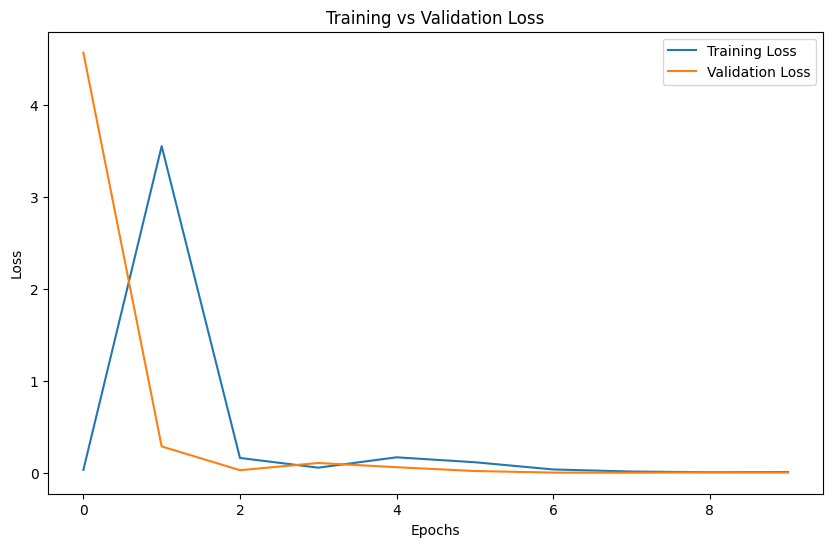

In [ ]:
import matplotlib.pyplot as plt

# Assume you have history from the model training process
# Example history object from training the model
# history = model.fit(...)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [ ]:
pip install seaborn matplotlib


In [ ]:
%matplotlib inline


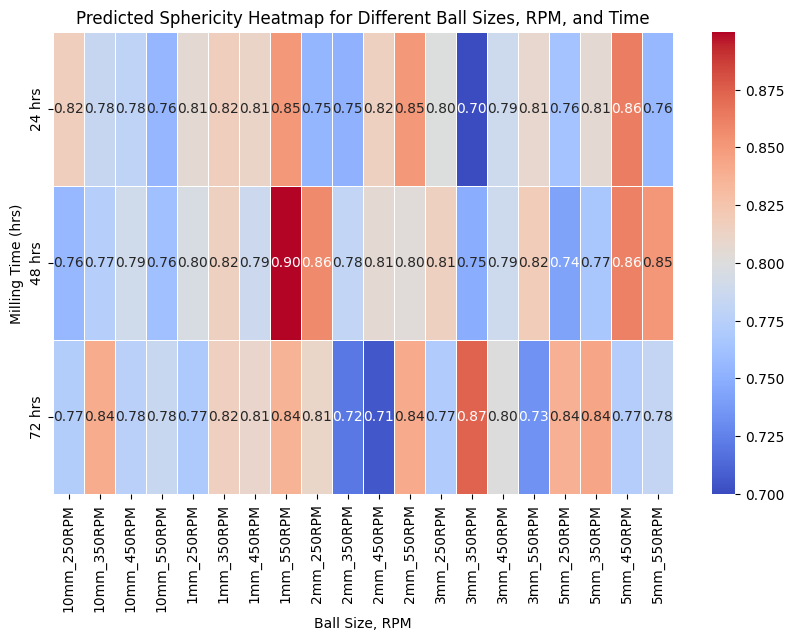

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Create a pivot table for heatmap (columns: RPM, rows: Milling Time, values: Predicted Sphericity)
heatmap_data = df_sphericity_sorted.pivot_table(
    index=["Time"],
    columns=["Ball Size, RPM"],
    values="Predicted Sphericity",
    aggfunc='mean'
)

# 🔹 Generate the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar=True, fmt=".2f", linewidths=0.5)

# 🔹 Add labels and title
plt.title("Predicted Sphericity Heatmap for Different Ball Sizes, RPM, and Time")
plt.xlabel("Ball Size, RPM")
plt.ylabel("Milling Time (hrs)")

# 🔹 Show the heatmap
plt.show()
